Kalman Predictor
Rolling Kalman filter prediction
Total data points: 501
Prediction points: 491
Minimum history length: 10
Time 0.200: Predicted=8.73, Actual=10.53, Error=1.79
Time 0.220: Predicted=9.06, Actual=11.00, Error=1.93
Time 0.240: Predicted=9.38, Actual=11.33, Error=1.95
Time 0.260: Predicted=9.68, Actual=12.18, Error=2.50
Time 0.280: Predicted=10.19, Actual=12.61, Error=2.42
Successfully predicted: 491 points

Prediction performance summary
Root mean square error (RMSE): 2.9414
Mean absolute error (MAE): 2.5488
Mean absolute percentage error (MAPE): 5.05%
Direction prediction accuracy: 53.9%
95% confidence interval coverage: 77.0%
Successfully predicted points: 491


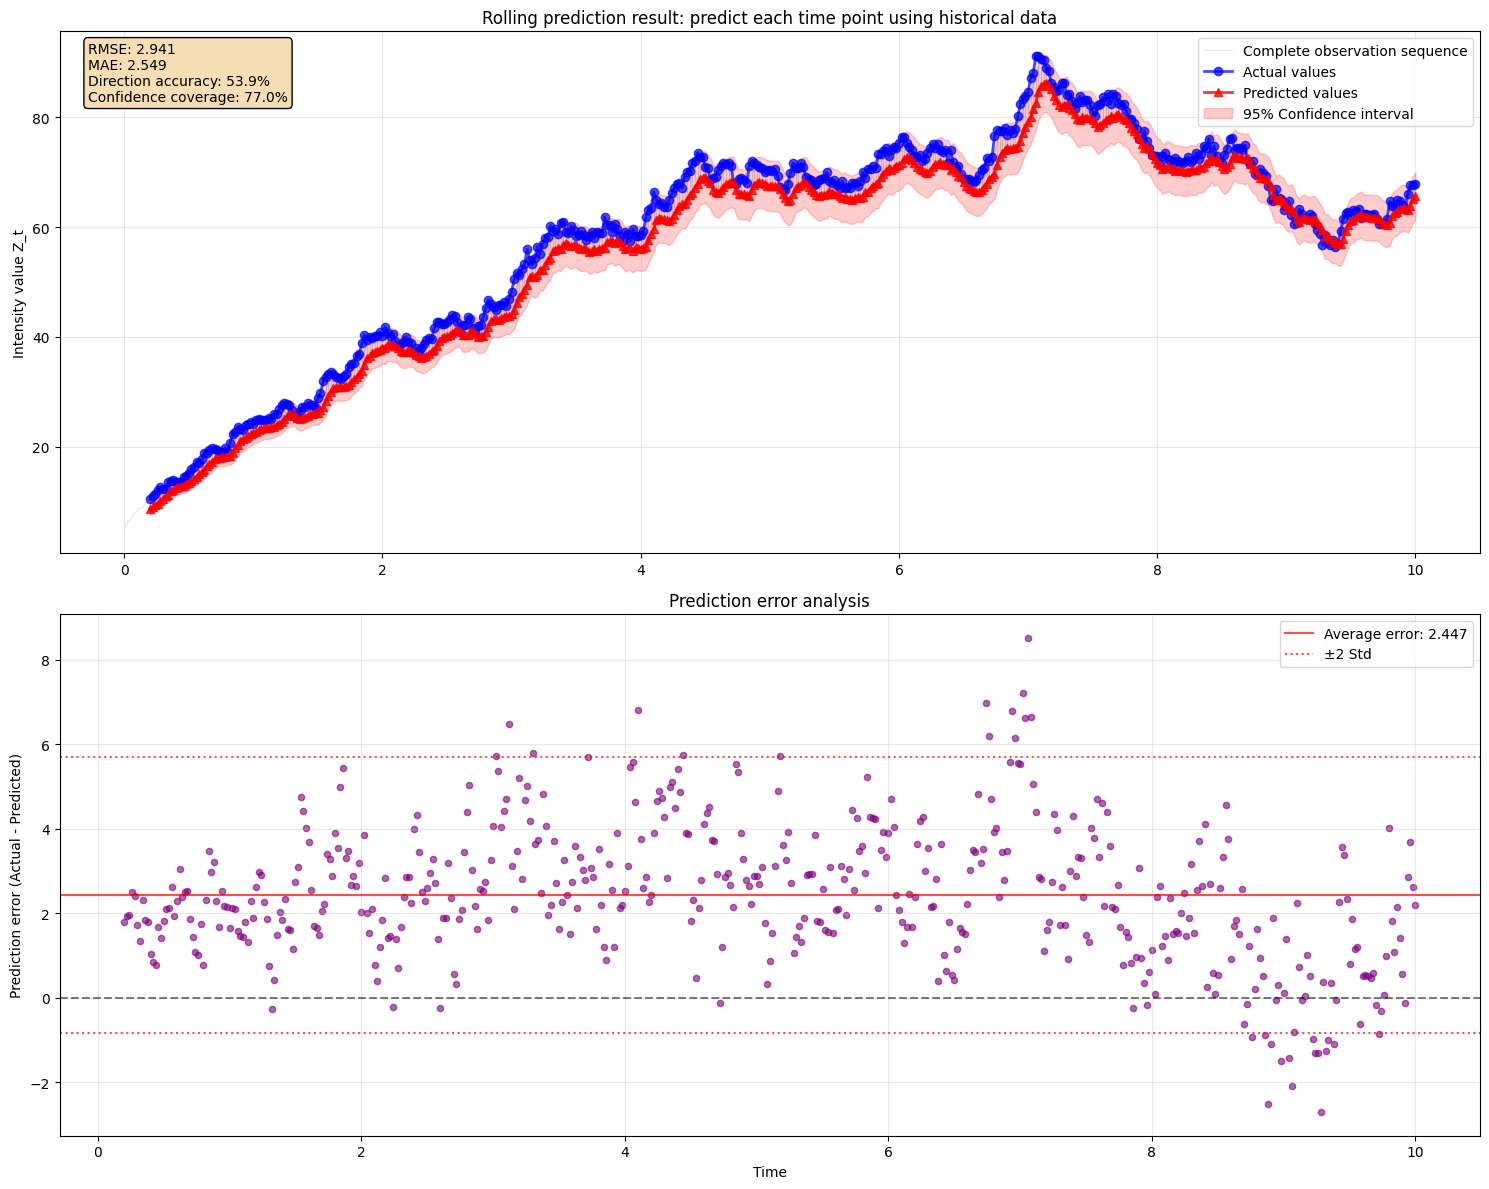


Usage:
result = rolling_kalman_predictor(data['time'], data['value'])
All prediction results in: result['detailed_results']

Printing PMF overlap:
Error loading histogram: pickle data was truncated
 Plotted PMF for window size 10
  PMF sum: 1.000000
  PMF range: [0.000000, 0.025662]
  PMF length: 301


AttributeError: 'Axes' object has no attribute '_axes_locator'

Error in callback <function _draw_all_if_interactive at 0x7fb8220b7760> (for post_execute), with arguments args (),kwargs {}:


AttributeError: 'Axes' object has no attribute '_animated'

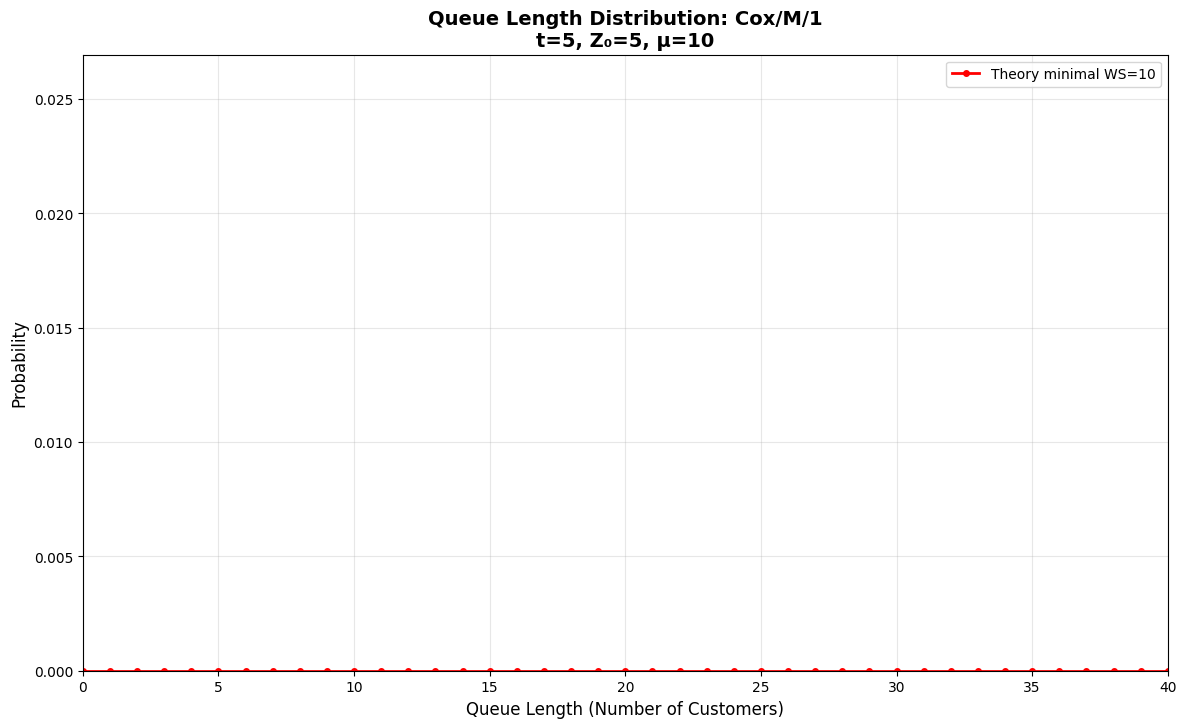

AttributeError: 'Axes' object has no attribute '_animated'

<Figure size 1400x800 with 2 Axes>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
from src.pmf import transient_distribution_piecewise
import os

class RollingKalmanPredictor:
    """
    Rolling Kalman Predictor
    
    For each time point t, use all historical data up to t to predict the value at t.
    """
    
    def __init__(self, min_history_length=5):
        """
        Initialize the rolling predictor
        
        Args:
            min_history_length: Minimum number of historical data points required for prediction
        """
        self.min_history_length = min_history_length
        self.results = {
            'prediction_times': [],      # Prediction time points
            'predictions': [],           # Predicted values
            'actual_values': [],         # Actual values
            'prediction_errors': [],     # Prediction errors
            'confidence_lower': [],      # Confidence interval lower bound
            'confidence_upper': [],      # Confidence interval upper bound
            'model_parameters': [],      # Model parameters for each prediction
            'used_history_length': []    # Number of historical data points used for each prediction
        }
    
    def estimate_parameters_window(self, times, values):
        """
        Estimate model parameters from a given time window
        
        Use moment estimation for fast parameter estimation
        """
        dt = np.mean(np.diff(times)) if len(times) > 1 else 0.1
        
        # Long-term mean
        b = np.mean(values)
        
        # Mean reversion speed (from lag-1 autocorrelation)
        if len(values) > 2:
            values_array = np.array(values)
            corr = np.corrcoef(values_array[:-1], values_array[1:])[0, 1]
            phi = max(0.05, min(0.95, corr))
            a = max(0.01, (1 - phi) / dt)
        else:
            a = 0.3
        
        # Volatility parameter
        if len(values) > 3:
            residuals = []
            for i in range(1, len(values)):
                predicted = values[i-1] + a * (b - values[i-1]) * dt
                residual = values[i] - predicted
                residuals.append(residual)
            
            if len(residuals) > 0:
                residual_var = np.var(residuals)
                sigma = np.sqrt(residual_var / (b * dt))
                sigma = max(0.1, min(3.0, sigma))
            else:
                sigma = 1.0
        else:
            sigma = 1.0
        
        return a, b, sigma, dt
    
    def kalman_one_step_prediction(self, times, values):
        """
        Use historical data for one-step prediction
        
        Args:
            times: Historical time series
            values: Historical observation sequence
            
        Returns:
            dict: Contains prediction value, uncertainty, etc.
        """
        if len(times) < 2:
            return None
        
        # Estimate model parameters (only using historical data)
        a, b, sigma, dt = self.estimate_parameters_window(times, values)
        
        # Initialize Kalman filter
        Z_current = values[0]
        P_current = 100.0
        
        # Update Kalman filter state using historical data
        for i in range(1, len(values)):
            # Prediction step
            Z_pred = Z_current + a * (b - Z_current) * dt
            F = 1 - a * dt
            Q = sigma**2 * max(0.1, Z_current) * dt
            P_pred = F * P_current * F + Q
            
            # Update step
            observation = values[i]
            H = 1.0
            R = max(1.0, 0.1 * abs(observation))
            S = H * P_pred * H + R
            K = P_pred * H / S
            
            innovation = observation - Z_pred
            Z_current = max(0.01, Z_pred + K * innovation)
            P_current = (1 - K * H) * P_pred
        
        # Next step prediction based on current state
        Z_next_pred = Z_current + a * (b - Z_current) * dt
        F = 1 - a * dt
        Q = sigma**2 * max(0.1, Z_current) * dt
        P_next_pred = F * P_current * F + Q
        
        # Calculate confidence interval
        std_pred = np.sqrt(P_next_pred)
        conf_lower = Z_next_pred - 1.96 * std_pred
        conf_upper = Z_next_pred + 1.96 * std_pred
        
        return {
            'prediction': Z_next_pred,
            'uncertainty': std_pred,
            'confidence_lower': conf_lower,
            'confidence_upper': conf_upper,
            'parameters': {'a': a, 'b': b, 'sigma': sigma, 'dt': dt}
        }
    
    def rolling_prediction(self, times, values, verbose=True):
        """
        Execute rolling prediction: for each time point, use previous data to predict the value at that point
        
        Args:
            times: Complete time series
            values: Complete observation sequence
            verbose: Whether to output detailed information
            
        Returns:
            dict: Summary of prediction results
        """
        # Validate input
        if len(times) != len(values):
            raise ValueError("times and values must have the same length")
        
        if len(times) < self.min_history_length + 1:
            raise ValueError(f"At least {self.min_history_length + 1} data points are required")
        
        # Ensure data is sorted by time
        sorted_indices = np.argsort(times)
        times = np.array(times)[sorted_indices]
        values = np.array(values)[sorted_indices]
        
        # Reset results
        self.results = {
            'prediction_times': [],
            'predictions': [],
            'actual_values': [],
            'prediction_errors': [],
            'confidence_lower': [],
            'confidence_upper': [],
            'model_parameters': [],
            'used_history_length': [],
            'predicted_step_function': [],
            'predicted_step_function_time_interval': []
        }
        
        if verbose:
            print("="*60)
            print("Rolling Kalman filter prediction")
            print("="*60)
            print(f"Total data points: {len(times)}")
            print(f"Prediction points: {len(times) - self.min_history_length}")
            print(f"Minimum history length: {self.min_history_length}")
        
        # For each time point, predict the value at that point (starting from the (min_history_length+1)th point)
        successful_predictions = 0
        self.results['predicted_step_function'] = [values[:self.min_history_length].mean()]
        self.results['predicted_step_function_time_interval'] = [times[self.min_history_length] - times[0]]
        last_current_time = times[self.min_history_length]
        for i in range(self.min_history_length, len(times)):
            # Use times[0:i] and values[0:i] to predict values[i]
            history_times = times[:i]
            history_values = values[:i]
            
            # Current time point and actual value to be predicted
            current_time = times[i]
            actual_value = values[i]
            
            # Perform prediction (only using historical data)
            pred_result = self.kalman_one_step_prediction(history_times, history_values)
            
            if pred_result is not None:
                prediction = pred_result['prediction']
                conf_lower = pred_result['confidence_lower']
                conf_upper = pred_result['confidence_upper']
                params = pred_result['parameters']
                
                # Store results
                if len(self.results['prediction_times']) == 0 or current_time != self.results['prediction_times'][-1]:
                    self.results['prediction_times'].append(current_time)
                    self.results['predicted_step_function'].append(prediction)
                    self.results['predicted_step_function_time_interval'].append(current_time -last_current_time)
                    last_current_time = current_time
                
                self.results['predictions'].append(prediction)
                self.results['actual_values'].append(actual_value)
                self.results['prediction_errors'].append(actual_value - prediction)
                self.results['confidence_lower'].append(conf_lower)
                self.results['confidence_upper'].append(conf_upper)
                self.results['model_parameters'].append(params)
                self.results['used_history_length'].append(len(history_times))
                
                successful_predictions += 1
                
                if verbose and i < self.min_history_length + 5:
                    print(f"Time {current_time:.3f}: Predicted={prediction:.2f}, Actual={actual_value:.2f}, "
                          f"Error={actual_value - prediction:.2f}")
        
        if verbose:
            print(f"Successfully predicted: {successful_predictions} points")
        
        return self.get_summary_metrics()
    
    def get_summary_metrics(self):
        """
        Calculate prediction performance metrics
        """
        if len(self.results['predictions']) == 0:
            return None
        
        predictions = np.array(self.results['predictions'])
        actuals = np.array(self.results['actual_values'])
        errors = np.array(self.results['prediction_errors'])
        
        # Calculate various metrics
        mse = np.mean(errors**2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(errors))
        mape = np.mean(np.abs(errors / actuals)) * 100
        
        # Direction accuracy (whether the predicted trend is correct)
        if len(actuals) > 1:
            actual_directions = np.sign(np.diff(actuals))
            pred_directions = np.sign(np.diff(predictions))
            direction_accuracy = np.mean(actual_directions == pred_directions) * 100
        else:
            direction_accuracy = 0
        
        # Confidence interval coverage
        lower_bounds = np.array(self.results['confidence_lower'])
        upper_bounds = np.array(self.results['confidence_upper'])
        coverage = np.mean((actuals >= lower_bounds) & (actuals <= upper_bounds)) * 100
        
        return {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'direction_accuracy': direction_accuracy,
            'confidence_coverage': coverage,
            'n_predictions': len(predictions),
            'mean_prediction': np.mean(predictions),
            'mean_actual': np.mean(actuals)
        }
    
    def plot_rolling_predictions(self, original_times=None, original_values=None, 
                               show_confidence=True, show_errors=True):
        """
        Plot rolling prediction results
        
        Args:
            original_times: Original complete time series (for context)
            original_values: Original complete observation sequence
            show_confidence: Whether to show confidence interval
            show_errors: Whether to show error plot
        """
        if len(self.results['predictions']) == 0:
            print("No prediction results to plot")
            return
        
        n_plots = 2 if show_errors else 1
        fig, axes = plt.subplots(n_plots, 1, figsize=(15, 6*n_plots))
        if n_plots == 1:
            axes = [axes]
        
        # Main plot: Predicted vs Actual
        ax1 = axes[0]
        
        # If original data is provided, plot the complete observation sequence as background
        if original_times is not None and original_values is not None:
            ax1.plot(original_times, original_values, 'lightgray', alpha=0.5, 
                    linewidth=1, label='Complete observation sequence')
        
        # Prediction and actual points
        pred_times = self.results['prediction_times']
        predictions = self.results['predictions']
        actual_values = self.results['actual_values']
        # Use line plots instead of scatter plots for actual and predicted values
        ax1.plot(pred_times, actual_values, color='blue', alpha=0.7, linewidth=2, 
                 label='Actual values', zorder=3, marker='o')
        ax1.plot(pred_times, predictions, color='red', alpha=0.8, linewidth=2, 
                 label='Predicted values', zorder=3, marker='^')
        
        # Connecting lines to show the relationship between predicted and actual values
        for i in range(len(pred_times)):
            ax1.plot([pred_times[i], pred_times[i]], 
                    [actual_values[i], predictions[i]], 
                    'gray', alpha=0.3, linewidth=1, zorder=1)
        
        # Confidence interval
        if show_confidence:
            conf_lower = self.results['confidence_lower']
            conf_upper = self.results['confidence_upper']
            ax1.fill_between(pred_times, conf_lower, conf_upper, 
                           alpha=0.2, color='red', label='95% Confidence interval')
        
        ax1.set_ylabel('Intensity value Z_t')
        ax1.set_title('Rolling prediction result: predict each time point using historical data')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Add performance metrics text
        metrics = self.get_summary_metrics()
        if metrics:
            metrics_text = (f'RMSE: {metrics["rmse"]:.3f}\n'
                           f'MAE: {metrics["mae"]:.3f}\n'
                           f'Direction accuracy: {metrics["direction_accuracy"]:.1f}%\n'
                           f'Confidence coverage: {metrics["confidence_coverage"]:.1f}%')
            ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))
        
        # Error plot
        if show_errors:
            ax2 = axes[1]
            errors = self.results['prediction_errors']
            
            ax2.scatter(pred_times, errors, color='purple', alpha=0.6, s=20)
            ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            
            # Error statistics line
            error_mean = np.mean(errors)
            error_std = np.std(errors)
            ax2.axhline(y=error_mean, color='red', linestyle='-', alpha=0.7, 
                       label=f'Average error: {error_mean:.3f}')
            ax2.axhline(y=error_mean + 2*error_std, color='red', linestyle=':', 
                       alpha=0.7, label='±2 Std')
            ax2.axhline(y=error_mean - 2*error_std, color='red', linestyle=':', alpha=0.7)
            
            ax2.set_ylabel('Prediction error (Actual - Predicted)')
            ax2.set_xlabel('Time')
            ax2.set_title('Prediction error analysis')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def get_prediction_at_time(self, target_time):
        """
        Get prediction results at a specific time point
        """
        for i, time in enumerate(self.results['prediction_times']):
            if abs(time - target_time) < 1e-6:
                return {
                    'time': time,
                    'prediction': self.results['predictions'][i],
                    'actual': self.results['actual_values'][i],
                    'error': self.results['prediction_errors'][i],
                    'confidence_lower': self.results['confidence_lower'][i],
                    'confidence_upper': self.results['confidence_upper'][i],
                    'history_length': self.results['used_history_length'][i]
                }
        return None

def rolling_kalman_predictor(times, values, min_history_length=5, verbose=True):
    """
    Main function: rolling Kalman filter prediction
    
    For each time point t (starting from the (min_history_length+1)th point), use historical data up to t to predict the value at t.
    
    Args:
        times: Time series
        values: Observation sequence  
        min_history_length: Minimum number of historical data points required for prediction
        verbose: Whether to display detailed information
        
    Returns:
        dict: Contains all prediction results and performance metrics
    """
    
    predictor = RollingKalmanPredictor(min_history_length=min_history_length)
    
    summary_metrics = predictor.rolling_prediction(times, values, verbose=verbose)
    
    if verbose and summary_metrics:
        print("\n" + "="*60)
        print("Prediction performance summary")
        print("="*60)
        print(f"Root mean square error (RMSE): {summary_metrics['rmse']:.4f}")
        print(f"Mean absolute error (MAE): {summary_metrics['mae']:.4f}")
        print(f"Mean absolute percentage error (MAPE): {summary_metrics['mape']:.2f}%")
        print(f"Direction prediction accuracy: {summary_metrics['direction_accuracy']:.1f}%")
        print(f"95% confidence interval coverage: {summary_metrics['confidence_coverage']:.1f}%")
        print(f"Successfully predicted points: {summary_metrics['n_predictions']}")
        print("="*60)
    
    predictor.plot_rolling_predictions(original_times=times, original_values=values)
    
    return {
        'predictor': predictor,
        'summary_metrics': summary_metrics,
        'detailed_results': predictor.results
    }

def plot_pmf_overlap(window_sizes, t, file_path, save_path, Z_piece, dt_piece, mu, m,
                    z_initial=80, hist_data_path=None, N=100, show_histogram=True):
    """
    Plot PMFs for different window sizes overlapped with simulation histogram.
    
    Args:
        window_sizes: List of window sizes to compare
        t: Time point for PMF calculation
        file_path: Source file path for reference (not used in current implementation)
        save_path: Directory to save the plot
        Z_piece: Predicted step function values
        dt_piece: Time intervals for step function
        mu: Model parameter mu (service rate)
        m: Model parameter m
        z_initial: Initial queue length (used for histogram file naming)
        hist_data_path: Path to histogram data directory
        N: Maximum number of states for PMF calculation
        show_histogram: Whether to overlay simulation histogram
    """
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    from pathlib import Path
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Define colors for theory curves
    theory_colors = ['red', 'darkgreen', 'orange', 'purple', 'brown']
    
    probabilities = None
    if show_histogram and hist_data_path:
        try:
            service_rate = 10 if z_initial == 5 else 100 if z_initial == 80 else mu
            hist_filename = f"/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/Simulation_histograms/for_histogram_CoxM1_Z0{z_initial}_serv{service_rate}_t{int(t)}.pickle"
            hist_path = hist_filename
            with open(hist_path, 'rb') as f:
                hist_data = pickle.load(f)
            
            counts = hist_data['counts']
            bins = hist_data['bins']
            
            if bins[0] != 0:
                bins = np.array(bins, dtype=int)
                interval = max(int(bins[1] - bins[0]), 1)
                bins_before = np.arange(0, bins[0], interval)
                bins = np.concatenate([bins_before, bins])
                counts_before = np.zeros(len(bins_before))
                counts = np.concatenate([counts_before, counts])
            
            # Normalize counts to probabilities
            total_count = np.sum(counts)
            if total_count > 0:
                probabilities = counts / total_count
                
                # Plot histogram
                x_hist = bins[:-1]
                ax.bar(x_hist, probabilities,
                      width=bins[1] - bins[0],
                      alpha=0.4,
                      color='lightblue',
                      label=f'Simulation t={int(t)}',
                      zorder=1)
                
                print(f"✓ Loaded histogram: {hist_filename}")
                print(f"  Total count: {total_count}")
                print(f"  Probability sum: {np.sum(probabilities):.6f}")
                print(f"  Histogram range: [{probabilities.min():.6f}, {probabilities.max():.6f}]")
            else:
                print(f"Warning: Empty histogram for {hist_filename}")
                
        except FileNotFoundError:
            print(f"Warning: Histogram file not found: {hist_filename}")
        except Exception as e:
            print(f"Error loading histogram: {e}")
    
    plotted_theory_curves = 0
    
    for idx, ws in enumerate(window_sizes):
        try:
            pt = transient_distribution_piecewise(Z_piece, dt_piece, mu, m, t=t, N=N)
            
            # Ensure we have valid PMF data
            if pt is None or len(pt) == 0:
                print(f"Warning: Empty PMF for window size {ws}")
                continue
            
            # Create x values for plotting
            x_vals = np.arange(len(pt))
            
            # Determine color
            color = theory_colors[idx] if idx < len(theory_colors) else f'C{idx}'
            
            # Plot PMF curve
            ax.plot(x_vals, pt,
                   marker='o',
                   linestyle='-',
                   color=color,
                   label=f'Theory minimal WS={ws}',
                   linewidth=2,
                   markersize=4,
                   zorder=2)
            
            print(f" Plotted PMF for window size {ws}")
            print(f"  PMF sum: {np.sum(pt):.6f}")
            print(f"  PMF range: [{np.min(pt):.6f}, {np.max(pt):.6f}]")
            print(f"  PMF length: {len(pt)}")
            
            plotted_theory_curves += 1
            
        except Exception as e:
            print(f"Error calculating PMF for window size {ws}: {e}")
            import traceback
            traceback.print_exc()
    
    # Configure plot appearance
    if plotted_theory_curves == 0:
        print("Warning: No theory curves were plotted")
    
    # Set plot properties
    ax.set_title(f'Queue Length Distribution: Cox/M/1\n'
                f't={int(t)}, Z₀={z_initial}, μ={mu}',
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Queue Length (Number of Customers)', fontsize=12)
    ax.set_ylabel('Probability', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    # Set axis limits intelligently
    x_max = N   
    
    if show_histogram and probabilities is not None and len(probabilities) > 0:
        max_prob = np.max(probabilities)
        meaningful_indices = np.where(probabilities > max_prob * 0.01)[0]
        if len(meaningful_indices) > 0:
            x_max = min(meaningful_indices[-1] + 5, N)
        else:
            x_max = min(40, N)
    else:
        x_max = min(40, N)
    
    ax.set_xlim(0, x_max)
    ax.set_ylim(bottom=0)
    
    # Ensure save directory exists and save plot
    save_dir = Path(save_path)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    filename = f"pmf_overlap_t{int(t)}.png"
    full_path = save_dir / filename
    
    plt.tight_layout()
    # plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ PMF overlap plot saved to {full_path}")
    print("-" * 50)
    
if __name__ == "__main__":
    np.random.seed(42)
    z_initial=5
    values = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['value']
    times = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['time']
    
    print("Kalman Predictor")
 
    # Execute rolling prediction
    min_history_length=10
    result = rolling_kalman_predictor(times, values, min_history_length=10, verbose=True)
    file_path_prediction = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/result_data/initial_value_80_samples_500_predicted_kalman_min_history_length_{min_history_length}.csv'
    pd.DataFrame(result).to_csv(file_path_prediction)
    
    print(f"\nUsage:")
    print(f"result = rolling_kalman_predictor(data['time'], data['value'])")
    print(f"All prediction results in: result['detailed_results']")
    
    print('\nPrinting PMF overlap:')
    file_path_pmf = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_80_samples_500_pmf_min_history_length_{min_history_length}/'   


    plot_pmf_overlap(
        [min_history_length],
        t=5,
        file_path=file_path_prediction,  # changed from 'file' to 'file_path'
        save_path=file_path_pmf,
        Z_piece=result['detailed_results']['predicted_step_function'],
        dt_piece=result['detailed_results']['predicted_step_function_time_interval'],
        mu=10 if z_initial == 5 else 100 if z_initial == 80 else 100,
        m=1,
        z_initial=z_initial,
        hist_data_path='/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/Simulation_histograms',
        N=300, # max number of states
        show_histogram=True
    )

Kalman Predictor
Rolling Kalman filter prediction
Total data points: 501
Prediction points: 491
Minimum history length: 10
Time 0.200: Predicted=8.73, Actual=10.53, Error=1.79
Time 0.220: Predicted=9.06, Actual=11.00, Error=1.93
Time 0.240: Predicted=9.38, Actual=11.33, Error=1.95
Time 0.260: Predicted=9.68, Actual=12.18, Error=2.50
Time 0.280: Predicted=10.19, Actual=12.61, Error=2.42
Successfully predicted: 491 points

Prediction performance summary
Root mean square error (RMSE): 2.9414
Mean absolute error (MAE): 2.5488
Mean absolute percentage error (MAPE): 5.05%
Direction prediction accuracy: 53.9%
95% confidence interval coverage: 77.0%
Successfully predicted points: 491


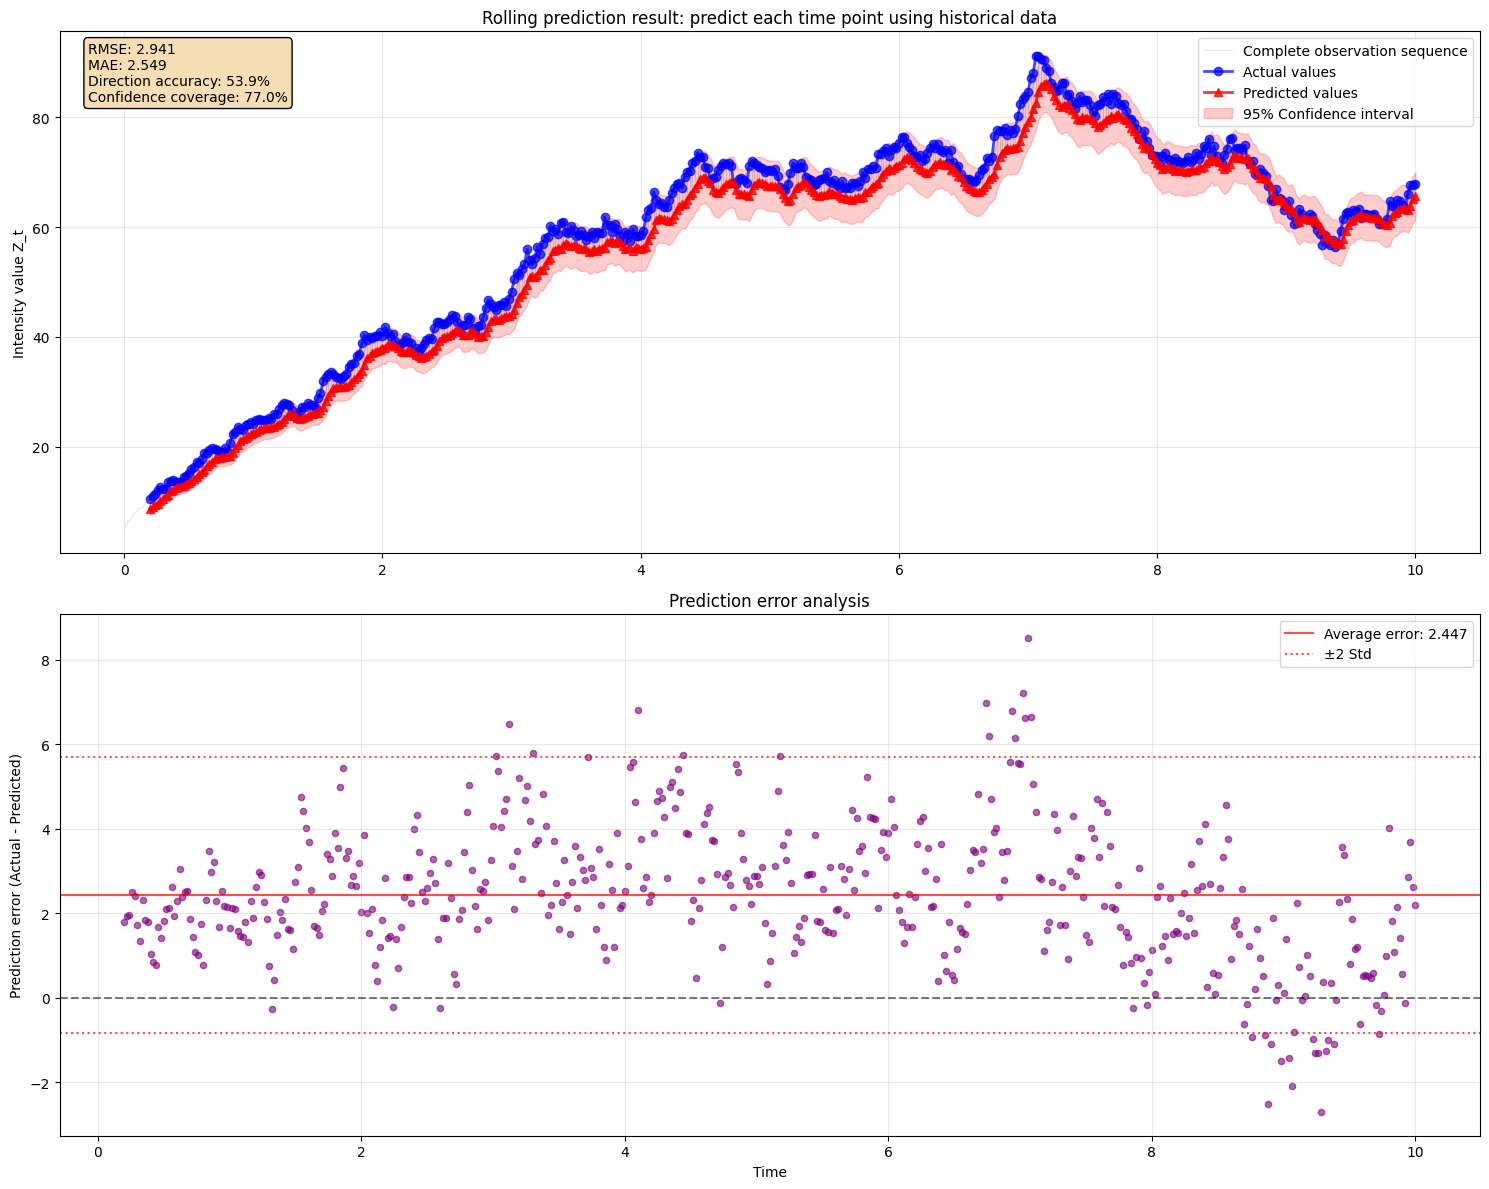


Usage:
result = rolling_kalman_predictor(data['time'], data['value'])
All prediction results in: result['detailed_results']

Printing PMF overlap:
Error loading histogram: pickle data was truncated
 Plotted PMF for window size 10
  PMF sum: 1.000000
  PMF range: [0.000000, 0.025662]
  PMF length: 301


AttributeError: 'Axes' object has no attribute '_axes_locator'

Error in callback <function _draw_all_if_interactive at 0x7fb8220b7760> (for post_execute), with arguments args (),kwargs {}:


AttributeError: 'Axes' object has no attribute '_animated'

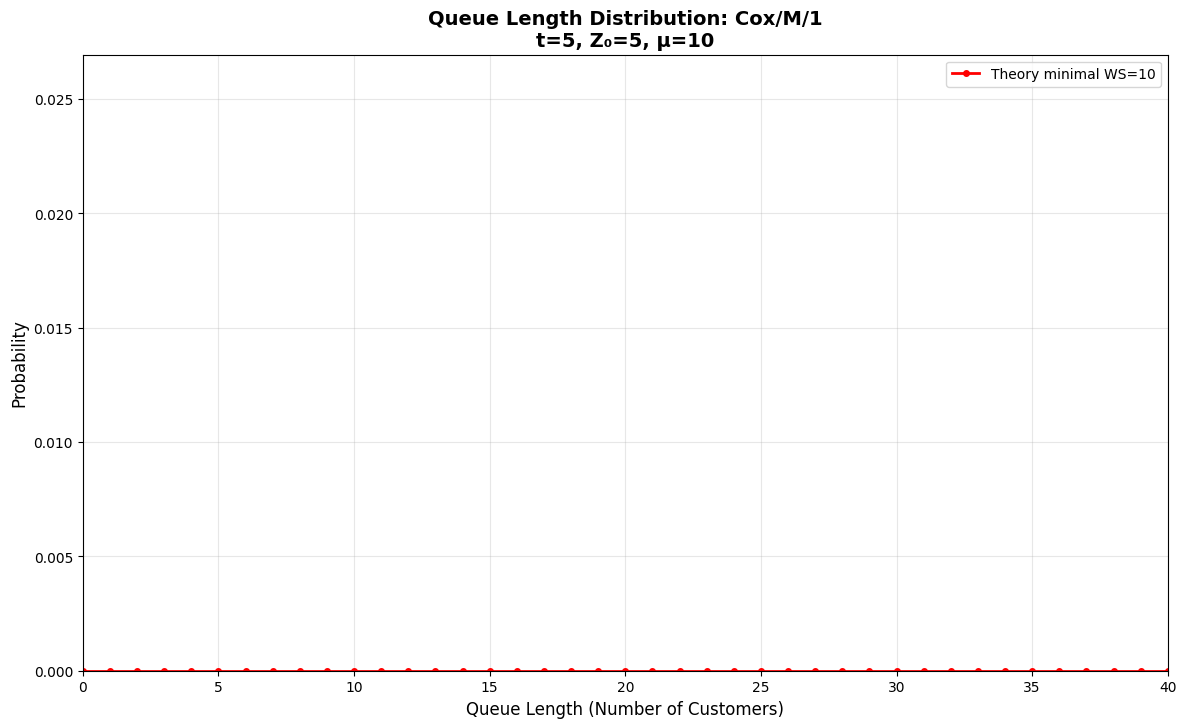

AttributeError: 'Axes' object has no attribute '_animated'

<Figure size 1400x800 with 2 Axes>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
from src.pmf import transient_distribution_piecewise
import os

class RollingKalmanPredictor:
    """
    Rolling Kalman Predictor
    
    For each time point t, use all historical data up to t to predict the value at t.
    """
    
    def __init__(self, min_history_length=5):
        """
        Initialize the rolling predictor
        
        Args:
            min_history_length: Minimum number of historical data points required for prediction
        """
        self.min_history_length = min_history_length
        self.results = {
            'prediction_times': [],      # Prediction time points
            'predictions': [],           # Predicted values
            'actual_values': [],         # Actual values
            'prediction_errors': [],     # Prediction errors
            'confidence_lower': [],      # Confidence interval lower bound
            'confidence_upper': [],      # Confidence interval upper bound
            'model_parameters': [],      # Model parameters for each prediction
            'used_history_length': []    # Number of historical data points used for each prediction
        }
    
    def estimate_parameters_window(self, times, values):
        """
        Estimate model parameters from a given time window
        
        Use moment estimation for fast parameter estimation
        """
        dt = np.mean(np.diff(times)) if len(times) > 1 else 0.1
        
        # Long-term mean
        b = np.mean(values)
        
        # Mean reversion speed (from lag-1 autocorrelation)
        if len(values) > 2:
            values_array = np.array(values)
            corr = np.corrcoef(values_array[:-1], values_array[1:])[0, 1]
            phi = max(0.05, min(0.95, corr))
            a = max(0.01, (1 - phi) / dt)
        else:
            a = 0.3
        
        # Volatility parameter
        if len(values) > 3:
            residuals = []
            for i in range(1, len(values)):
                predicted = values[i-1] + a * (b - values[i-1]) * dt
                residual = values[i] - predicted
                residuals.append(residual)
            
            if len(residuals) > 0:
                residual_var = np.var(residuals)
                sigma = np.sqrt(residual_var / (b * dt))
                sigma = max(0.1, min(3.0, sigma))
            else:
                sigma = 1.0
        else:
            sigma = 1.0
        
        return a, b, sigma, dt
    
    def kalman_one_step_prediction(self, times, values):
        """
        Use historical data for one-step prediction
        
        Args:
            times: Historical time series
            values: Historical observation sequence
            
        Returns:
            dict: Contains prediction value, uncertainty, etc.
        """
        if len(times) < 2:
            return None
        
        # Estimate model parameters (only using historical data)
        a, b, sigma, dt = self.estimate_parameters_window(times, values)
        
        # Initialize Kalman filter
        Z_current = values[0]
        P_current = 100.0
        
        # Update Kalman filter state using historical data
        for i in range(1, len(values)):
            # Prediction step
            Z_pred = Z_current + a * (b - Z_current) * dt
            F = 1 - a * dt
            Q = sigma**2 * max(0.1, Z_current) * dt
            P_pred = F * P_current * F + Q
            
            # Update step
            observation = values[i]
            H = 1.0
            R = max(1.0, 0.1 * abs(observation))
            S = H * P_pred * H + R
            K = P_pred * H / S
            
            innovation = observation - Z_pred
            Z_current = max(0.01, Z_pred + K * innovation)
            P_current = (1 - K * H) * P_pred
        
        # Next step prediction based on current state
        Z_next_pred = Z_current + a * (b - Z_current) * dt
        F = 1 - a * dt
        Q = sigma**2 * max(0.1, Z_current) * dt
        P_next_pred = F * P_current * F + Q
        
        # Calculate confidence interval
        std_pred = np.sqrt(P_next_pred)
        conf_lower = Z_next_pred - 1.96 * std_pred
        conf_upper = Z_next_pred + 1.96 * std_pred
        
        return {
            'prediction': Z_next_pred,
            'uncertainty': std_pred,
            'confidence_lower': conf_lower,
            'confidence_upper': conf_upper,
            'parameters': {'a': a, 'b': b, 'sigma': sigma, 'dt': dt}
        }
    
    def rolling_prediction(self, times, values, verbose=True):
        """
        Execute rolling prediction: for each time point, use previous data to predict the value at that point
        
        Args:
            times: Complete time series
            values: Complete observation sequence
            verbose: Whether to output detailed information
            
        Returns:
            dict: Summary of prediction results
        """
        # Validate input
        if len(times) != len(values):
            raise ValueError("times and values must have the same length")
        
        if len(times) < self.min_history_length + 1:
            raise ValueError(f"At least {self.min_history_length + 1} data points are required")
        
        # Ensure data is sorted by time
        sorted_indices = np.argsort(times)
        times = np.array(times)[sorted_indices]
        values = np.array(values)[sorted_indices]
        
        # Reset results
        self.results = {
            'prediction_times': [],
            'predictions': [],
            'actual_values': [],
            'prediction_errors': [],
            'confidence_lower': [],
            'confidence_upper': [],
            'model_parameters': [],
            'used_history_length': [],
            'predicted_step_function': [],
            'predicted_step_function_time_interval': []
        }
        
        if verbose:
            print("="*60)
            print("Rolling Kalman filter prediction")
            print("="*60)
            print(f"Total data points: {len(times)}")
            print(f"Prediction points: {len(times) - self.min_history_length}")
            print(f"Minimum history length: {self.min_history_length}")
        
        # For each time point, predict the value at that point (starting from the (min_history_length+1)th point)
        successful_predictions = 0
        self.results['predicted_step_function'] = [values[:self.min_history_length].mean()]
        self.results['predicted_step_function_time_interval'] = [times[self.min_history_length] - times[0]]
        last_current_time = times[self.min_history_length]
        for i in range(self.min_history_length, len(times)):
            # Use times[0:i] and values[0:i] to predict values[i]
            history_times = times[:i]
            history_values = values[:i]
            
            # Current time point and actual value to be predicted
            current_time = times[i]
            actual_value = values[i]
            
            # Perform prediction (only using historical data)
            pred_result = self.kalman_one_step_prediction(history_times, history_values)
            
            if pred_result is not None:
                prediction = pred_result['prediction']
                conf_lower = pred_result['confidence_lower']
                conf_upper = pred_result['confidence_upper']
                params = pred_result['parameters']
                
                # Store results
                if len(self.results['prediction_times']) == 0 or current_time != self.results['prediction_times'][-1]:
                    self.results['prediction_times'].append(current_time)
                    self.results['predicted_step_function'].append(prediction)
                    self.results['predicted_step_function_time_interval'].append(current_time -last_current_time)
                    last_current_time = current_time
                
                self.results['predictions'].append(prediction)
                self.results['actual_values'].append(actual_value)
                self.results['prediction_errors'].append(actual_value - prediction)
                self.results['confidence_lower'].append(conf_lower)
                self.results['confidence_upper'].append(conf_upper)
                self.results['model_parameters'].append(params)
                self.results['used_history_length'].append(len(history_times))
                
                successful_predictions += 1
                
                if verbose and i < self.min_history_length + 5:
                    print(f"Time {current_time:.3f}: Predicted={prediction:.2f}, Actual={actual_value:.2f}, "
                          f"Error={actual_value - prediction:.2f}")
        
        if verbose:
            print(f"Successfully predicted: {successful_predictions} points")
        
        return self.get_summary_metrics()
    
    def get_summary_metrics(self):
        """
        Calculate prediction performance metrics
        """
        if len(self.results['predictions']) == 0:
            return None
        
        predictions = np.array(self.results['predictions'])
        actuals = np.array(self.results['actual_values'])
        errors = np.array(self.results['prediction_errors'])
        
        # Calculate various metrics
        mse = np.mean(errors**2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(errors))
        mape = np.mean(np.abs(errors / actuals)) * 100
        
        # Direction accuracy (whether the predicted trend is correct)
        if len(actuals) > 1:
            actual_directions = np.sign(np.diff(actuals))
            pred_directions = np.sign(np.diff(predictions))
            direction_accuracy = np.mean(actual_directions == pred_directions) * 100
        else:
            direction_accuracy = 0
        
        # Confidence interval coverage
        lower_bounds = np.array(self.results['confidence_lower'])
        upper_bounds = np.array(self.results['confidence_upper'])
        coverage = np.mean((actuals >= lower_bounds) & (actuals <= upper_bounds)) * 100
        
        return {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'direction_accuracy': direction_accuracy,
            'confidence_coverage': coverage,
            'n_predictions': len(predictions),
            'mean_prediction': np.mean(predictions),
            'mean_actual': np.mean(actuals)
        }
    
    def plot_rolling_predictions(self, original_times=None, original_values=None, 
                               show_confidence=True, show_errors=True):
        """
        Plot rolling prediction results
        
        Args:
            original_times: Original complete time series (for context)
            original_values: Original complete observation sequence
            show_confidence: Whether to show confidence interval
            show_errors: Whether to show error plot
        """
        if len(self.results['predictions']) == 0:
            print("No prediction results to plot")
            return
        
        n_plots = 2 if show_errors else 1
        fig, axes = plt.subplots(n_plots, 1, figsize=(15, 6*n_plots))
        if n_plots == 1:
            axes = [axes]
        
        # Main plot: Predicted vs Actual
        ax1 = axes[0]
        
        # If original data is provided, plot the complete observation sequence as background
        if original_times is not None and original_values is not None:
            ax1.plot(original_times, original_values, 'lightgray', alpha=0.5, 
                    linewidth=1, label='Complete observation sequence')
        
        # Prediction and actual points
        pred_times = self.results['prediction_times']
        predictions = self.results['predictions']
        actual_values = self.results['actual_values']
        # Use line plots instead of scatter plots for actual and predicted values
        ax1.plot(pred_times, actual_values, color='blue', alpha=0.7, linewidth=2, 
                 label='Actual values', zorder=3, marker='o')
        ax1.plot(pred_times, predictions, color='red', alpha=0.8, linewidth=2, 
                 label='Predicted values', zorder=3, marker='^')
        
        # Connecting lines to show the relationship between predicted and actual values
        for i in range(len(pred_times)):
            ax1.plot([pred_times[i], pred_times[i]], 
                    [actual_values[i], predictions[i]], 
                    'gray', alpha=0.3, linewidth=1, zorder=1)
        
        # Confidence interval
        if show_confidence:
            conf_lower = self.results['confidence_lower']
            conf_upper = self.results['confidence_upper']
            ax1.fill_between(pred_times, conf_lower, conf_upper, 
                           alpha=0.2, color='red', label='95% Confidence interval')
        
        ax1.set_ylabel('Intensity value Z_t')
        ax1.set_title('Rolling prediction result: predict each time point using historical data')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Add performance metrics text
        metrics = self.get_summary_metrics()
        if metrics:
            metrics_text = (f'RMSE: {metrics["rmse"]:.3f}\n'
                           f'MAE: {metrics["mae"]:.3f}\n'
                           f'Direction accuracy: {metrics["direction_accuracy"]:.1f}%\n'
                           f'Confidence coverage: {metrics["confidence_coverage"]:.1f}%')
            ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))
        
        # Error plot
        if show_errors:
            ax2 = axes[1]
            errors = self.results['prediction_errors']
            
            ax2.scatter(pred_times, errors, color='purple', alpha=0.6, s=20)
            ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            
            # Error statistics line
            error_mean = np.mean(errors)
            error_std = np.std(errors)
            ax2.axhline(y=error_mean, color='red', linestyle='-', alpha=0.7, 
                       label=f'Average error: {error_mean:.3f}')
            ax2.axhline(y=error_mean + 2*error_std, color='red', linestyle=':', 
                       alpha=0.7, label='±2 Std')
            ax2.axhline(y=error_mean - 2*error_std, color='red', linestyle=':', alpha=0.7)
            
            ax2.set_ylabel('Prediction error (Actual - Predicted)')
            ax2.set_xlabel('Time')
            ax2.set_title('Prediction error analysis')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def get_prediction_at_time(self, target_time):
        """
        Get prediction results at a specific time point
        """
        for i, time in enumerate(self.results['prediction_times']):
            if abs(time - target_time) < 1e-6:
                return {
                    'time': time,
                    'prediction': self.results['predictions'][i],
                    'actual': self.results['actual_values'][i],
                    'error': self.results['prediction_errors'][i],
                    'confidence_lower': self.results['confidence_lower'][i],
                    'confidence_upper': self.results['confidence_upper'][i],
                    'history_length': self.results['used_history_length'][i]
                }
        return None

def rolling_kalman_predictor(times, values, min_history_length=5, verbose=True):
    """
    Main function: rolling Kalman filter prediction
    
    For each time point t (starting from the (min_history_length+1)th point), use historical data up to t to predict the value at t.
    
    Args:
        times: Time series
        values: Observation sequence  
        min_history_length: Minimum number of historical data points required for prediction
        verbose: Whether to display detailed information
        
    Returns:
        dict: Contains all prediction results and performance metrics
    """
    
    predictor = RollingKalmanPredictor(min_history_length=min_history_length)
    
    summary_metrics = predictor.rolling_prediction(times, values, verbose=verbose)
    
    if verbose and summary_metrics:
        print("\n" + "="*60)
        print("Prediction performance summary")
        print("="*60)
        print(f"Root mean square error (RMSE): {summary_metrics['rmse']:.4f}")
        print(f"Mean absolute error (MAE): {summary_metrics['mae']:.4f}")
        print(f"Mean absolute percentage error (MAPE): {summary_metrics['mape']:.2f}%")
        print(f"Direction prediction accuracy: {summary_metrics['direction_accuracy']:.1f}%")
        print(f"95% confidence interval coverage: {summary_metrics['confidence_coverage']:.1f}%")
        print(f"Successfully predicted points: {summary_metrics['n_predictions']}")
        print("="*60)
    
    predictor.plot_rolling_predictions(original_times=times, original_values=values)
    
    return {
        'predictor': predictor,
        'summary_metrics': summary_metrics,
        'detailed_results': predictor.results
    }

def plot_pmf_overlap(window_sizes, t, file_path, save_path, Z_piece, dt_piece, mu, m,
                    z_initial=80, hist_data_path=None, N=100, show_histogram=True):
    """
    Plot PMFs for different window sizes overlapped with simulation histogram.
    
    Args:
        window_sizes: List of window sizes to compare
        t: Time point for PMF calculation
        file_path: Source file path for reference (not used in current implementation)
        save_path: Directory to save the plot
        Z_piece: Predicted step function values
        dt_piece: Time intervals for step function
        mu: Model parameter mu (service rate)
        m: Model parameter m
        z_initial: Initial queue length (used for histogram file naming)
        hist_data_path: Path to histogram data directory
        N: Maximum number of states for PMF calculation
        show_histogram: Whether to overlay simulation histogram
    """
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    from pathlib import Path
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Define colors for theory curves
    theory_colors = ['red', 'darkgreen', 'orange', 'purple', 'brown']
    
    probabilities = None
    if show_histogram and hist_data_path:
        try:
            service_rate = 10 if z_initial == 5 else 100 if z_initial == 80 else mu
            hist_filename = f"/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/Simulation_histograms/for_histogram_CoxM1_Z0{z_initial}_serv{service_rate}_t{int(t)}.pickle"
            hist_path = hist_filename
            with open(hist_path, 'rb') as f:
                hist_data = pickle.load(f)
            
            counts = hist_data['counts']
            bins = hist_data['bins']
            
            if bins[0] != 0:
                bins = np.array(bins, dtype=int)
                interval = max(int(bins[1] - bins[0]), 1)
                bins_before = np.arange(0, bins[0], interval)
                bins = np.concatenate([bins_before, bins])
                counts_before = np.zeros(len(bins_before))
                counts = np.concatenate([counts_before, counts])
            
            # Normalize counts to probabilities
            total_count = np.sum(counts)
            if total_count > 0:
                probabilities = counts / total_count
                
                # Plot histogram
                x_hist = bins[:-1]
                ax.bar(x_hist, probabilities,
                      width=bins[1] - bins[0],
                      alpha=0.4,
                      color='lightblue',
                      label=f'Simulation t={int(t)}',
                      zorder=1)
                
                print(f"✓ Loaded histogram: {hist_filename}")
                print(f"  Total count: {total_count}")
                print(f"  Probability sum: {np.sum(probabilities):.6f}")
                print(f"  Histogram range: [{probabilities.min():.6f}, {probabilities.max():.6f}]")
            else:
                print(f"Warning: Empty histogram for {hist_filename}")
                
        except FileNotFoundError:
            print(f"Warning: Histogram file not found: {hist_filename}")
        except Exception as e:
            print(f"Error loading histogram: {e}")
    
    plotted_theory_curves = 0
    
    for idx, ws in enumerate(window_sizes):
        try:
            pt = transient_distribution_piecewise(Z_piece, dt_piece, mu, m, t=t, N=N)
            
            # Ensure we have valid PMF data
            if pt is None or len(pt) == 0:
                print(f"Warning: Empty PMF for window size {ws}")
                continue
            
            # Create x values for plotting
            x_vals = np.arange(len(pt))
            
            # Determine color
            color = theory_colors[idx] if idx < len(theory_colors) else f'C{idx}'
            
            # Plot PMF curve
            ax.plot(x_vals, pt,
                   marker='o',
                   linestyle='-',
                   color=color,
                   label=f'Theory minimal WS={ws}',
                   linewidth=2,
                   markersize=4,
                   zorder=2)
            
            print(f" Plotted PMF for window size {ws}")
            print(f"  PMF sum: {np.sum(pt):.6f}")
            print(f"  PMF range: [{np.min(pt):.6f}, {np.max(pt):.6f}]")
            print(f"  PMF length: {len(pt)}")
            
            plotted_theory_curves += 1
            
        except Exception as e:
            print(f"Error calculating PMF for window size {ws}: {e}")
            import traceback
            traceback.print_exc()
    
    # Configure plot appearance
    if plotted_theory_curves == 0:
        print("Warning: No theory curves were plotted")
    
    # Set plot properties
    ax.set_title(f'Queue Length Distribution: Cox/M/1\n'
                f't={int(t)}, Z₀={z_initial}, μ={mu}',
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Queue Length (Number of Customers)', fontsize=12)
    ax.set_ylabel('Probability', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    # Set axis limits intelligently
    x_max = N   
    
    if show_histogram and probabilities is not None and len(probabilities) > 0:
        max_prob = np.max(probabilities)
        meaningful_indices = np.where(probabilities > max_prob * 0.01)[0]
        if len(meaningful_indices) > 0:
            x_max = min(meaningful_indices[-1] + 5, N)
        else:
            x_max = min(40, N)
    else:
        x_max = min(40, N)
    
    ax.set_xlim(0, x_max)
    ax.set_ylim(bottom=0)
    
    # Ensure save directory exists and save plot
    save_dir = Path(save_path)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    filename = f"pmf_overlap_t{int(t)}.png"
    full_path = save_dir / filename
    
    plt.tight_layout()
    # plt.savefig(full_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ PMF overlap plot saved to {full_path}")
    print("-" * 50)
    
if __name__ == "__main__":
    np.random.seed(42)
    z_initial=5
    values = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['value']
    times = pd.read_csv(f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/arrival_data/initial_value_{z_initial}_samples_500.csv')['time']
    
    print("Kalman Predictor")
 
    # Execute rolling prediction
    min_history_length=10
    result = rolling_kalman_predictor(times, values, min_history_length=10, verbose=True)
    file_path_prediction = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/result_data/initial_value_80_samples_500_predicted_kalman_min_history_length_{min_history_length}.csv'
    pd.DataFrame(result).to_csv(file_path_prediction)
    
    print(f"\nUsage:")
    print(f"result = rolling_kalman_predictor(data['time'], data['value'])")
    print(f"All prediction results in: result['detailed_results']")
    
    print('\nPrinting PMF overlap:')
    file_path_pmf = f'/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/pmf_data/M=500/initial_value_80_samples_500_pmf_min_history_length_{min_history_length}/'   


    plot_pmf_overlap(
        [min_history_length],
        t=5,
        file_path=file_path_prediction,  # changed from 'file' to 'file_path'
        save_path=file_path_pmf,
        Z_piece=result['detailed_results']['predicted_step_function'],
        dt_piece=result['detailed_results']['predicted_step_function_time_interval'],
        mu=10 if z_initial == 5 else 100 if z_initial == 80 else 100,
        m=1,
        z_initial=z_initial,
        hist_data_path='/home/oxj7986/Cox_Arrivals/change-point-detection/data_integrated/Simulation_histograms',
        N=300, # max number of states
        show_histogram=True
    )